# Testing MiniscoPy with true data

MiniscopPy is a Python 3.0 implementation of the CNMF-E algorithm (Zhou et al., 2016). It has been optimized for the MiniScope (Cai et al., 2016), a portable microscope for calcium imaging in freely moving animals.


## BASIC IMPORTS

In [24]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from time import time
from matplotlib.pyplot import *
import scipy
import glob
import yaml
import sys,os
import h5py as hd
from time import time
import av
#specific to miniscopy
from miniscopy.base.motion_correction import *
from miniscopy import setup_cluster, CNMFE, generate_data, get_default_parameters

## LISTING THE MOVIES & LOADING THE PARAMETERS

The miniscope recording system usually outputs a set of avi files in one folder. First, give the path of this folder and list all the avi files within it. Then, save a file that list all the parameters in a yaml format (see parameters.yaml in the miniscoPy/example_movies/). It's better to have one parameters.yaml per recording folder (the same for the entire session)

### DOWNLOADING AN EXAMPLE FILE IF NOT ALREADY PRESENT

In [25]:
folder_name = 'example_movies'
files = glob.glob(folder_name+'/*.avi')
if len(files) == 0:
    import urllib.request
    url = "https://www.dropbox.com/s/0x3twp8bidl9svu/msCam1.avi?dl=1"
    with urllib.request.urlopen(url) as response, open(folder_name+"/msCam1.avi", 'wb') as out_file:
        data = response.read()
        out_file.write(data)
    files = glob.glob(folder_name+'/*.avi')
    if len(files) == 0: print("No avi files found, please provide one at least")

print(files)


['example_movies/msCam1.avi']


### Loading the parameters
When cloning from Github, the parameter file should already be present in /example_movies.

In [26]:
parameters = yaml.load(open(folder_name+'/parameters.yaml', 'r'))

## STARTING THE CLUSTER (OPTIONAL)
For now, pool mapping is used only for the motion correction algorithm. Instantiating "procs = None" works as well, it all depends on your local configuration.

In [27]:
c, procs, n_processes = setup_cluster(backend='local', n_processes=8, single_thread=False)
#procs = None

## MOTION CORRECTION

This function implements Normcorre (see...). All the outputs and associated information are stored in one HDF5 per session that will eventually be used for detection of calcium transients. 

In [28]:
data, video_info = normcorre(files, procs, parameters['motion_correction'])

100%|██████████| 125/125 [01:18<00:00,  1.59it/s]


Here are some information about the dataset in a [Pandas](https://pandas.pydata.org/) dataframe. It is very helpful to match with behavioral data.

In [29]:
print(video_info) # some information about the dataset

                            start   end duration
  file_name                                     
0 example_movies/msCam1.avi     0  1000     1000


## WORKING WITH HDF5

The HDF5 file (called data in this example) contains a Numpy array called 'movie' of size (number of frames, number of pixels). The cool thing about HDF5 format is that you can attach attributes (i.e. extra information) to every dataset or group it contains. Here, we attached the attributes of the frame dimension and the recording duration to the dataset 'movie'.

In [30]:
print(data['movie'].attrs['dims']) # width and height of the frame
print(data['movie'].attrs['duration']) # number of frames
print(data.attrs['folder'])
print(data.attrs['filename'])

[480 752]
1000
example_movies
example_movies/motion_corrected.hdf5


In the following example, the datasets contains additional attributes such as the animal's identity and frame rate. Both are located at the root of the HDF5 file.

In [31]:
# let's set some attributes
data.attrs['animal_name'] = '123456_AB'
data.attrs['frame_rate'] = 30

Let's check the first frame of the movie to see if it's in correct order.

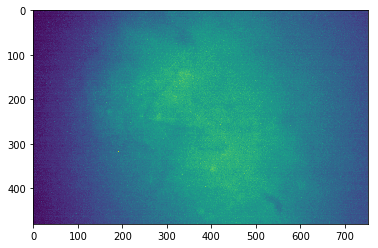

In [32]:
dims = data['movie'].attrs['dims']
frame_0 = data['movie'][0].reshape(dims)
figure()
imshow(frame_0)
show()

## RUNNING CNMF-E 

In [33]:
parameters['cnmfe']['init_params']['thresh_init'] = 1.2
parameters['cnmfe']['init_params']['min_corr'] = 0.8
parameters['cnmfe']['init_params']['min_pnr'] = 1.5

cnm = CNMFE(data, parameters['cnmfe'])
cnm.fit(procs)

100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


No neurons merged!
Total time :  414.0516  second


## VISUALIZATION



In [34]:
procs.terminate()

cn, pnr = cnm.get_correlation_info()


Here all the spatial footprints (the A matrix) are normalized between 0 and 1 and the sum of all responses is then displayed.

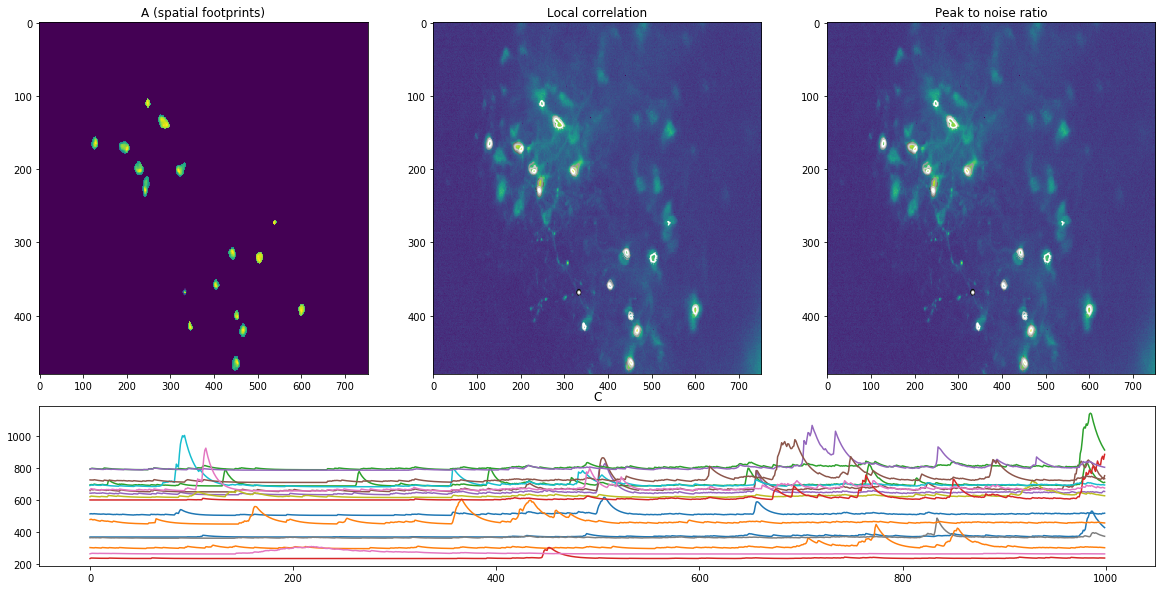

In [37]:
dims = cnm.dims
C = cnm.C.value.copy()
A = cnm.A.value.copy()

# A is normalized to 1 for display
A -= np.vstack(A.min(1))
A /= np.vstack(A.max(1))
Atotal = A.sum(0).reshape(dims)


from matplotlib.pyplot import *
import matplotlib.gridspec as gridspec

tmp = Atotal.copy()
tmp[tmp == 0] = np.nan
figure(figsize = (20,10))
gs = gridspec.GridSpec(3,3)
subplot(gs[0:2,0])
imshow(Atotal, aspect = 'auto')
title("A (spatial footprints)")
subplot(gs[0:2,1])
imshow(cn, aspect = 'auto')
contour(np.flip(tmp, 0), origin = 'upper', cmap = 'gist_gray')
title("Local correlation")
subplot(gs[0:2,2])
imshow(cn, aspect = 'auto')
contour(np.flip(tmp, 0), origin = 'upper', cmap = 'gist_gray')
title("Peak to noise ratio")
subplot(gs[-1,:])
plot(C)
title("C")

show()